## Создадим датасет

### Начальная установка

Установим необходимые завсимости

In [ ]:
# %pip install PySpice

In [ ]:
# %conda install -c conda-forge ngspice-exe

In [ ]:
# %conda install -c conda-forge ngspice

In [ ]:
# %conda install -c conda-forge ngspice-lib

### Необходимый импорт

In [8]:
import numpy as np

In [1]:
####################################################################################################

import matplotlib.pyplot as plt

####################################################################################################

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()

####################################################################################################

from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Probe.Plot import plot
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *

####################################################################################################

Промоделируем работу MOSFET транзистора

In [2]:
spice_library = SpiceLibrary("C:/Users/lario/MyAnacondaProject/example/libraries")

In [3]:
for key in spice_library.models:
    print(key)

BAV21
BAV21@xyce
2n2222a
ptm32nm_nmos
ptm32nm_pmos
ptm65nm_nmos
ptm65nm_pmos


In [483]:
def mos_circuit(params=None):
    d = {'vg': 1, 'vd': 2, 'length': 1e-6, 'width':10e-6, 'temp': 25}
    if params: 
        for k, v in params.items():
            d[k] = v
            
    circuit = Circuit('MOS circuit')
    circuit.model('NMOS-SH', 'nmos', Kp=190e-6, Vto=0.57, Lambda=0.16, Gamma=0.50, Phi=0.7)
    circuit.V('G', 'VG', 0, d['vg'])
    circuit.V('D', 'VD', 0, d['vd'])
    circuit.M(1, 'VD', 'VG', 0, 0, model='NMOS-SH', l=d['length'], w=d['width'], temp=d['temp'])


#     circuit.include(spice_library['ptm32nm_nmos'])
#     circuit.M(1, 'VD', 'VG', 0, 0, model='ptm32nm_nmos', l=d['length'], w=d['width'])
#     circuit.MOSFET(1, 'VD', 'VG', circuit.gnd, circuit.gnd, model='ptm65nm_nmos')
    return circuit

print(mos_circuit())

.title MOS circuit
VG VG 0 1
VD VD 0 2
M1 VD VG 0 0 NMOS-SH l=1e-06 temp=25 w=1e-05
.model NMOS-SH nmos (Gamma=0.5 Kp=0.00019 Lambda=0.16 Phi=0.7 Vto=0.57)



In [484]:
def sweep_source(first_source_name, first_source_range, second_source_name, second_source_range):
    y = []
    
    for s in second_source_range:
        circuit = mos_circuit({f'{second_source_name}':s})
        
        if second_source_name == 'temp':
            simulator = circuit.simulator(temperature=s, normal_temperature=25)
        else:
            simulator = circuit.simulator(temperature=25, normal_temperature=25)
            
        if first_source_name == 'vg':
            analysis = simulator.dc(VG=first_source_range)
        else:
            analysis = simulator.dc(VD=first_source_range)
        y.append(- np.array(analysis.branches['vd']))
        
    x = np.array(analysis.nodes[first_source_name])
    return x, y

In [485]:
def plot(x_label, y_label, title, first_source_name, x, y, second_source_name, second_source_range, func=lambda x: x):
    fig, ax = plt.subplots(figsize=(8, 4))
    
    ax.set(xlabel=x_label, ylabel=y_label, title=title)
    ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)
    
    for i, s in enumerate(second_source_range):
        ax.plot(x, func(y[i]), label=f'{second_source_name} = {str(s)}V')
    
    ax.legend()
    plt.show()

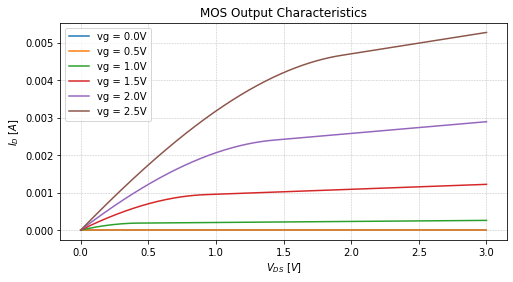

In [24]:
first_source_name = 'vd'
first_source_range = slice(0, 3, .01)
second_source_name = 'vg'
second_source_range = np.arange(0, 3, 0.5)

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = '$V_{DS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'MOS Output Characteristics'

plot(x_label, y_label, title, first_source_name, x, y, second_source_name, second_source_range)

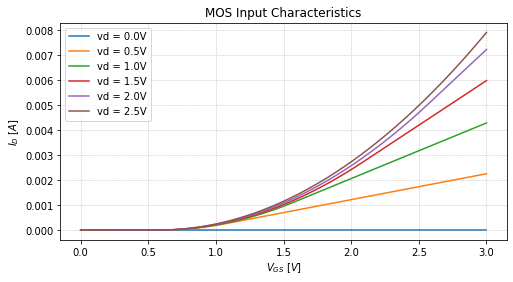

In [25]:
first_source_name = 'vg'
first_source_range = slice(0, 3, .01)
second_source_name = 'vd'
second_source_range = np.arange(0, 3, 0.5)

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = '$V_{GS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'MOS Input Characteristics'

plot(x_label, y_label, title, first_source_name, x, y, second_source_name, second_source_range)

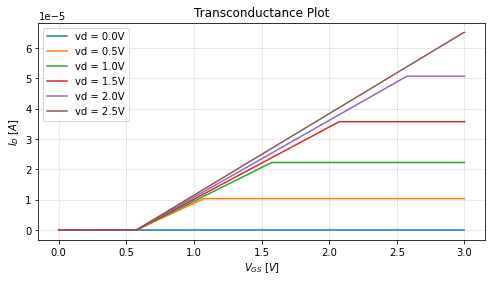

In [26]:
first_source_name = 'vg'
first_source_range = slice(0, 3, .01)
second_source_name = 'vd'
second_source_range = np.arange(0, 3, 0.5)

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = '$V_{GS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'Transconductance Plot'

plot(x_label, y_label, title, first_source_name, x, y, second_source_name, second_source_range, np.gradient)

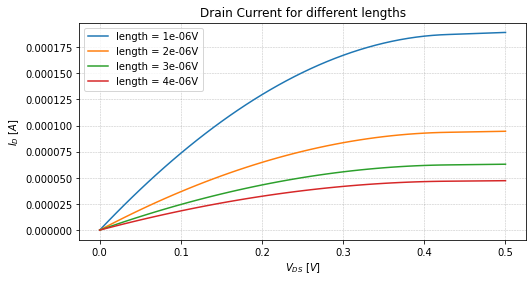

In [27]:
first_source_name = 'vd'
first_source_range = slice(0, 0.5, .01)
second_source_name = 'length'
second_source_range = np.arange(1, 5, 1) * 1e-6

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = '$V_{DS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'Drain Current for different lengths'

plot(x_label, y_label, title, first_source_name, x, y, second_source_name, second_source_range)

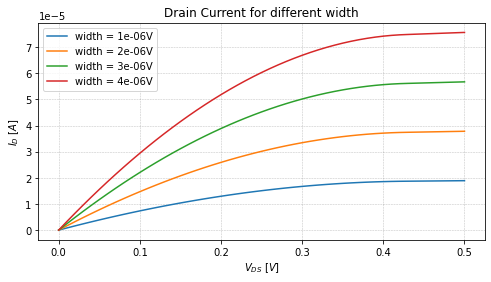

In [28]:
first_source_name = 'vd'
first_source_range = slice(0, 0.5, .01)
second_source_name = 'width'
second_source_range = np.arange(1, 5, 1) * 1e-6

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = '$V_{DS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'Drain Current for different width'

plot(x_label, y_label, title, first_source_name, x, y, second_source_name, second_source_range)

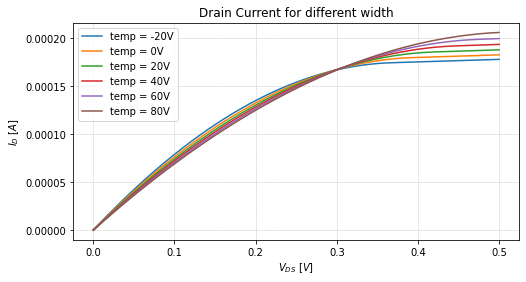

In [29]:
first_source_name = 'vd'
first_source_range = slice(0, 0.5, .01)
second_source_name = 'temp'
second_source_range = np.arange(-20, 100, 20)

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = '$V_{DS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'Drain Current for different width'

plot(x_label, y_label, title, first_source_name, x, y, second_source_name, second_source_range)

### Создание датасета

Давайте создадим датасет с двумя параметрами Vds и Vgs

In [486]:
####################################################################################################

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# для progress bar
from tqdm import tqdm

####################################################################################################

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()

####################################################################################################

from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Probe.Plot import plot
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *

####################################################################################################

Будем использовать одну цепь для всех датасетов

In [487]:
def mos_circuit(params=None):
    d = {'vg': 1, 'vd': 2, 'length': 1e-6, 'width':10e-6, 'temp': 25}
    if params: 
        for k, v in params.items():
            d[k] = v
            
    circuit = Circuit('MOS circuit')
    circuit.model('NMOS-SH', 'nmos', Kp=190e-6, Vto=0.57, Lambda=0.16, Gamma=0.50, Phi=0.7)
    circuit.V('G', 'VG', 0, d['vg'])
    circuit.V('D', 'VD', 0, d['vd'])
    circuit.M(1, 'VD', 'VG', 0, 0, model='NMOS-SH', l=d['length'], w=d['width'], temp=d['temp'])


#     circuit.include(spice_library['ptm32nm_nmos'])
#     circuit.M(1, 'VD', 'VG', 0, 0, model='ptm32nm_nmos', l=d['length'], w=d['width'])
#     circuit.MOSFET(1, 'VD', 'VG', circuit.gnd, circuit.gnd, model='ptm65nm_nmos')
    return circuit

print(mos_circuit())

.title MOS circuit
VG VG 0 1
VD VD 0 2
M1 VD VG 0 0 NMOS-SH l=1e-06 temp=25 w=1e-05
.model NMOS-SH nmos (Gamma=0.5 Kp=0.00019 Lambda=0.16 Phi=0.7 Vto=0.57)



Добавим разброс ширины для шума

In [488]:
def dataset_2p(vd_slice, vg_range, noise_width):
    dataset = {'Vds': [], 'Vgs': [], 'Id': []}
    Vds = np.array([])
    Vgs = np.array([])
    Id  = np.array([])
    
    for w in noise_width:
        for vg in vg_range:
            circuit = mos_circuit({'vg':vg, 'width': w})
            simulator = circuit.simulator(temperature=25, normal_temperature=25)
            analysis = simulator.dc(VD=vd_slice)
        
            id_range = (- np.array(analysis.branches['vd']))
            len_id = len(id_range)
        
            vd_range = np.arange(vd_slice.start, vd_slice.stop + vd_slice.step, vd_slice.step)
        
            Vds = np.hstack((Vds, vd_range))
            Vgs = np.hstack((Vgs, [vg] * len_id))
            Id  = np.hstack((Id, id_range))

    dataset['Vds'] = Vds.tolist()
    dataset['Vgs'] = Vgs.tolist()
    dataset['Id'] = Id.tolist()
        
    dataset = pd.DataFrame(dataset)
    return dataset

In [489]:
np.arange(0.98, 1.02, .005)

array([0.98 , 0.985, 0.99 , 0.995, 1.   , 1.005, 1.01 , 1.015, 1.02 ])

In [298]:
data = dataset_2p(vd_slice = slice(0, 5, .01),
                vg_range = np.arange(0, 5.1, 0.5), 
                noise_width = np.arange(0.98, 1.02, .005) * 1e-6)
data

,Vds,Vgs,Id
0,0.00,0.0,-0.000000e+00
1,0.01,0.0,1.285481e-14
2,0.02,0.0,2.396719e-14
3,0.03,0.0,3.505294e-14
4,0.04,0.0,4.578862e-14
...,...,...,...
49594,4.96,5.0,3.440861e-03
49595,4.97,5.0,3.443930e-03
49596,4.98,5.0,3.447000e-03
49597,4.99,5.0,3.450069e-03


Сохраним и загрузим датасет

In [299]:
file_name = 'mosfet_2p.csv'
data.to_csv(file_name, index=None)

In [300]:
df = pd.read_csv('mosfet_2p.csv')
df

,Vds,Vgs,Id
0,0.00,0.0,-0.000000e+00
1,0.01,0.0,1.285481e-14
2,0.02,0.0,2.396719e-14
3,0.03,0.0,3.505294e-14
4,0.04,0.0,4.578862e-14
...,...,...,...
49594,4.96,5.0,3.440861e-03
49595,4.97,5.0,3.443930e-03
49596,4.98,5.0,3.447000e-03
49597,4.99,5.0,3.450069e-03


Давайте посмотрим на данные, которые мы получили

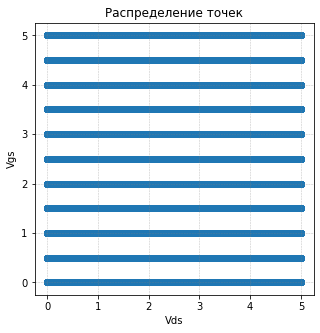

In [301]:
x = df['Vds']
y = df['Vgs']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Vds', ylabel='Vgs', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x, y)
plt.show()

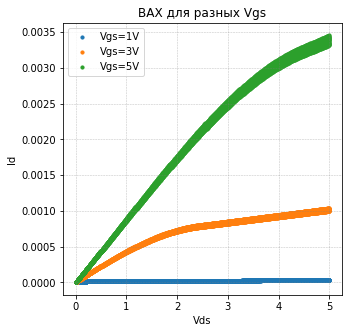

In [311]:
def get_x_y(df, vg):
    x = df[df['Vgs'] == vg]['Vds']
    y = df[df['Vgs'] == vg]['Id']
    return x, y

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Vds', ylabel='Id', title='ВАХ для разных Vgs')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

x, y = get_x_y(df, 1.)
plt.scatter(x, y, s=10, label='Vgs=1V')

x, y = get_x_y(df, 3.)
plt.scatter(x, y, s=10, label='Vgs=3V')

x, y = get_x_y(df, 5.)
plt.scatter(x, y, s=10, label='Vgs=5V')
plt.legend()
plt.show()

### Данные для валидации

Данные внутри области обучения

In [318]:
data_val = dataset_2p(vd_slice = slice(0, 5, .01),
                    vg_range = np.arange(0, 5.1, 0.1), 
                    noise_width = [1e-6])
file_name = 'mosfet_2p_val_1.csv'
data_val.to_csv(file_name, index=None)
data_val

,Vds,Vgs,Id
0,0.00,0.0,-0.000000e+00
1,0.01,0.0,1.285481e-14
2,0.02,0.0,2.396719e-14
3,0.03,0.0,3.505294e-14
4,0.04,0.0,4.578862e-14
...,...,...,...
25546,4.96,5.0,3.373393e-03
25547,4.97,5.0,3.376402e-03
25548,4.98,5.0,3.379411e-03
25549,4.99,5.0,3.382421e-03


Данные вне области обучения

In [319]:
data_val = dataset_2p(vd_slice = slice(5, 9, .01),
                    vg_range = np.arange(5, 7, .1), 
                    noise_width = [1e-6])
file_name = 'mosfet_2p_val_2.csv'
data_val.to_csv(file_name, index=None)
data_val

,Vds,Vgs,Id
0,5.00,5.0,0.003385
1,5.01,5.0,0.003388
2,5.02,5.0,0.003391
3,5.03,5.0,0.003394
4,5.04,5.0,0.003397
...,...,...,...
8015,8.96,6.9,0.009349
8016,8.97,6.9,0.009355
8017,8.98,6.9,0.009361
8018,8.99,6.9,0.009367


## Датасет для нескольких параметров (Vds, Vgs, Length, Width, Temp)

In [320]:
def _join_cross(vg_range, l_range, w_range, temp_range):
    ans = []
    for vg in vg_range:
        for l in l_range:
            for w in w_range:
                for t in temp_range:
                    ans.append((vg, l, w, t))
    return np.array(ans)

_join_cross([1, 2], [3, 4], [5, 6], [7, 8])[:5]

array([[1, 3, 5, 7],
       [1, 3, 5, 8],
       [1, 3, 6, 7],
       [1, 3, 6, 8],
       [1, 4, 5, 7]])

In [325]:
def dataset(vd_slice, params_range):
    dataset = {'Vds': [], 'Vgs': [], 'L': [], 'W': [], 'T': [], 'Id': []}
    Vds = np.array([])
    Vgs = np.array([])
    L   = np.array([])
    W   = np.array([])
    T   = np.array([])
    Id  = np.array([])
    
    for vg, l, w, temp in tqdm(params_range):
        circuit = mos_circuit({'vg':vg, 'length': l, 'width': w, 'temp': temp})
        simulator = circuit.simulator(temperature=temp, normal_temperature=25)
        analysis = simulator.dc(VD=vd_slice)
        
        id_range = (- np.array(analysis.branches['vd']))
        len_id = len(id_range)
        
        vd_range = np.arange(vd_slice.start, vd_slice.stop + vd_slice.step, vd_slice.step)
        
        Vds = np.hstack((Vds, vd_range))
        Vgs = np.hstack((Vgs, [vg] * len_id))
        L   = np.hstack((L, [l] * len_id))
        W   = np.hstack((W, [w] * len_id))
        T   = np.hstack((T, [temp] * len_id))
        Id  = np.hstack((Id, id_range))

    dataset['Vds'] = Vds.tolist()
    dataset['Vgs'] = Vgs.tolist()
    dataset['L'] = L.tolist()
    dataset['W'] = W.tolist()
    dataset['T'] = T.tolist()
    dataset['Id'] = Id.tolist()
        
    dataset = pd.DataFrame(dataset, index=None)
    return dataset

In [336]:
np.arange(1, 10, 3)

array([1, 4, 7])

len(W) + len(L) = 16 (шт) -- Всего транзисторов

In [410]:
params_range = _join_cross(vg_range=np.arange(0, 5.1, 0.5),
                           l_range=np.arange(1, 12, 3) * 1e-6, 
                           w_range=np.arange(1, 12, 3) * 1e-6, 
                           temp_range=np.arange(-20, 100, 20),
                          )
data = dataset(slice(0, 5, .01), params_range)
data

100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [00:35<00:00, 30.14it/s]


,Vds,Vgs,L,W,T,Id
0,0.00,0.0,0.000001,0.000001,-20.0,-0.000000e+00
1,0.01,0.0,0.000001,0.000001,-20.0,1.000089e-14
2,0.02,0.0,0.000001,0.000001,-20.0,2.000116e-14
3,0.03,0.0,0.000001,0.000001,-20.0,3.000145e-14
4,0.04,0.0,0.000001,0.000001,-20.0,4.000163e-14
...,...,...,...,...,...,...
529051,4.96,5.0,0.000010,0.000010,80.0,2.710961e-03
529052,4.97,5.0,0.000010,0.000010,80.0,2.713380e-03
529053,4.98,5.0,0.000010,0.000010,80.0,2.715798e-03
529054,4.99,5.0,0.000010,0.000010,80.0,2.718216e-03


In [411]:
data.shape

(529056, 6)

Сохраним и загрузим датасет

In [412]:
file_name = 'mosfet.csv'
data.to_csv(file_name, index=None)

In [424]:
df = pd.read_csv('mosfet.csv')
df

,Vds,Vgs,L,W,T,Id
0,0.00,0.0,0.000001,0.000001,-20.0,-0.000000e+00
1,0.01,0.0,0.000001,0.000001,-20.0,1.000089e-14
2,0.02,0.0,0.000001,0.000001,-20.0,2.000116e-14
3,0.03,0.0,0.000001,0.000001,-20.0,3.000145e-14
4,0.04,0.0,0.000001,0.000001,-20.0,4.000163e-14
...,...,...,...,...,...,...
529051,4.96,5.0,0.000010,0.000010,80.0,2.710961e-03
529052,4.97,5.0,0.000010,0.000010,80.0,2.713380e-03
529053,4.98,5.0,0.000010,0.000010,80.0,2.715798e-03
529054,4.99,5.0,0.000010,0.000010,80.0,2.718216e-03


In [414]:
df['Vgs'].unique()

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

In [415]:
df['L'].unique()

array([1.e-06, 4.e-06, 7.e-06, 1.e-05])

In [416]:
df['W'].unique()

array([1.e-06, 4.e-06, 7.e-06, 1.e-05])

In [417]:
df['T'].unique()

array([-20.,   0.,  20.,  40.,  60.,  80.])

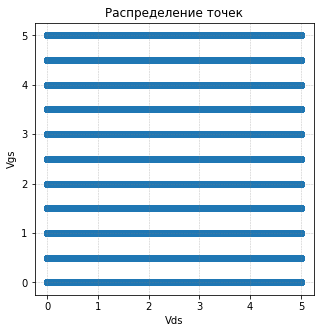

In [418]:
x = df['Vds']
y = df['Vgs']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Vds', ylabel='Vgs', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x, y)
plt.show()

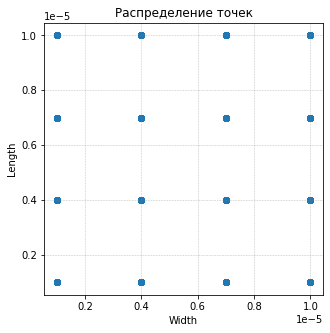

In [432]:
x = df[df['T'] == df.iloc[0]['T']]['W']
y = df[df['T'] == df.iloc[0]['T']]['L']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Width', ylabel='Length', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x, y)
plt.show()

In [420]:
df.iloc[1]['L']

1e-06

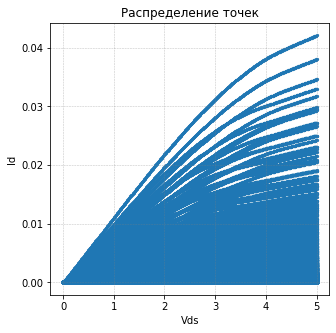

In [421]:
x = df['Vds']
y = df['Id']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Vds', ylabel='Id', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x, y, s=5)
plt.show()

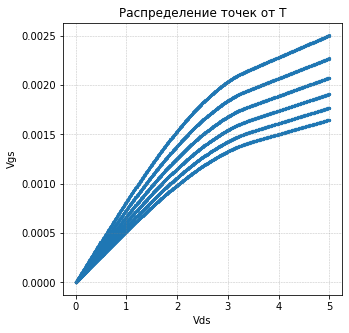

In [422]:
x = df[(df['L'] == df.iloc[10]['L']) & (df['W'] == df.iloc[10]['W']) & (df['Vgs'] == 4.)]['Vds']
y = df[(df['L'] == df.iloc[10]['L']) & (df['W'] == df.iloc[10]['W']) & (df['Vgs'] == 4.)]['Id']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Vds', ylabel='Vgs', title='Распределение точек от T')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x, y, s=5)
plt.show()

### Данные для валидации

Данные внутри области обучения

In [438]:
np.arange(2.5, 12, 3)

array([ 2.5,  5.5,  8.5, 11.5])

In [439]:
np.arange(1, 12, 3)

array([ 1,  4,  7, 10])

In [458]:
params_range_val = _join_cross(vg_range=np.arange(0.25, 5.1, 0.5),
                           l_range=np.arange(2.5, 12, 3) * 1e-6, 
                           w_range=np.arange(2.5, 12, 3) * 1e-6, 
                           temp_range=np.arange(-15, 90, 10),
                          )
data_val = dataset(slice(0, 5, .1), params_range_val)
data_val

100%|██████████████████████████████████████████████████████████████████████████████| 1760/1760 [00:29<00:00, 60.52it/s]


,Vds,Vgs,L,W,T,Id
0,0.0,0.25,0.000002,0.000002,-15.0,-0.000000e+00
1,0.1,0.25,0.000002,0.000002,-15.0,1.000250e-13
2,0.2,0.25,0.000002,0.000002,-15.0,2.000056e-13
3,0.3,0.25,0.000002,0.000002,-15.0,3.000056e-13
4,0.4,0.25,0.000002,0.000002,-15.0,4.000056e-13
...,...,...,...,...,...,...
89755,4.6,4.75,0.000012,0.000012,85.0,2.300000e-03
89756,4.7,4.75,0.000012,0.000012,85.0,2.321198e-03
89757,4.8,4.75,0.000012,0.000012,85.0,2.342396e-03
89758,4.9,4.75,0.000012,0.000012,85.0,2.363594e-03


In [459]:
file_name = 'mosfet_val_0.csv'
data_val.to_csv(file_name, index=None)

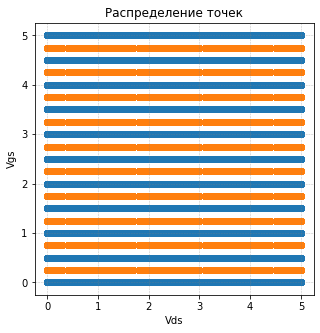

In [460]:
x = df[df['T'] == df.iloc[0]['T']]['Vds']
y = df[df['T'] == df.iloc[0]['T']]['Vgs']

x_val = data_val[data_val['T'] == data_val.iloc[0]['T']]['Vds']
y_val = data_val[data_val['T'] == data_val.iloc[0]['T']]['Vgs']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Vds', ylabel='Vgs', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x, y)
plt.scatter(x_val, y_val)
plt.show()

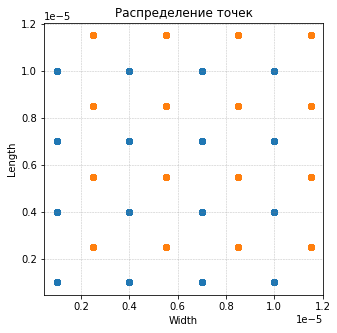

In [461]:
x = df[df['T'] == df.iloc[0]['T']]['W']
y = df[df['T'] == df.iloc[0]['T']]['L']

x_val = data_val[data_val['T'] == data_val.iloc[0]['T']]['W']
y_val = data_val[data_val['T'] == data_val.iloc[0]['T']]['L']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Width', ylabel='Length', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x, y)
plt.scatter(x_val, y_val)
plt.show()

Валидационные данные вне области обучения

In [466]:
params_range_val = _join_cross(vg_range=np.arange(0.01, 8, 0.5),
                           l_range=np.arange(5, 20, 3) * 1e-6, 
                           w_range=np.arange(5, 20, 3) * 1e-6, 
                           temp_range=np.arange(-30, 90, 10),
                          )
data_val = dataset(slice(0, 8, .5), params_range_val)
data_val

100%|██████████████████████████████████████████████████████████████████████████████| 4800/4800 [01:14<00:00, 64.02it/s]


,Vds,Vgs,L,W,T,Id
0,0.0,0.01,0.000005,0.000005,-30.0,-0.000000e+00
1,0.5,0.01,0.000005,0.000005,-30.0,5.000049e-13
2,1.0,0.01,0.000005,0.000005,-30.0,1.000000e-12
3,1.5,0.01,0.000005,0.000005,-30.0,1.500000e-12
4,2.0,0.01,0.000005,0.000005,-30.0,2.000000e-12
...,...,...,...,...,...,...
81595,6.0,7.51,0.000017,0.000017,80.0,7.031310e-03
81596,6.5,7.51,0.000017,0.000017,80.0,7.434640e-03
81597,7.0,7.51,0.000017,0.000017,80.0,7.768190e-03
81598,7.5,7.51,0.000017,0.000017,80.0,8.061372e-03


In [467]:
file_name = 'mosfet_val_1.csv'
data_val.to_csv(file_name, index=None)

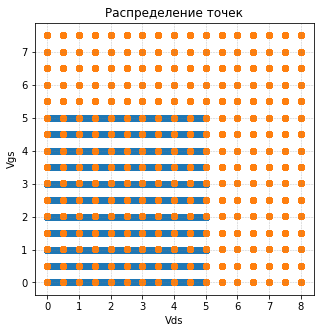

In [468]:
x = df[df['T'] == df.iloc[0]['T']]['Vds']
y = df[df['T'] == df.iloc[0]['T']]['Vgs']

x_val = data_val[data_val['T'] == data_val.iloc[0]['T']]['Vds']
y_val = data_val[data_val['T'] == data_val.iloc[0]['T']]['Vgs']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Vds', ylabel='Vgs', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x, y)
plt.scatter(x_val, y_val)
plt.show()

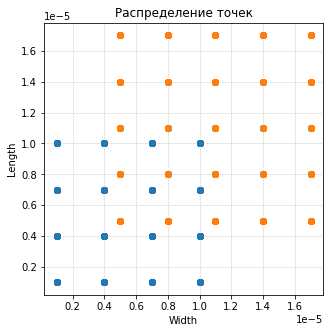

In [469]:
x = df[df['T'] == df.iloc[0]['T']]['W']
y = df[df['T'] == df.iloc[0]['T']]['L']

x_val = data_val[data_val['T'] == data_val.iloc[0]['T']]['W']
y_val = data_val[data_val['T'] == data_val.iloc[0]['T']]['L']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Width', ylabel='Length', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x, y)
plt.scatter(x_val, y_val)
plt.show()

Данные для графиков

In [479]:
data_val = dataset(slice(0, 8, .5), [(0.5, 5 * 1e-6, 5 * 1e-6, 25)])

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56it/s]


In [480]:
file_name = 'mosfet_val_3.csv'
data_val.to_csv(file_name, index=None)

In [481]:
data_val = dataset(slice(0, 8, .5), [(4, 15 * 1e-6, 15 * 1e-6, 25)])
file_name = 'mosfet_val_4.csv'
data_val.to_csv(file_name, index=None)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.74it/s]


In [482]:
data_val = dataset(slice(0, 8, .5), [(5, 15 * 1e-6, 15 * 1e-6, 90)])
file_name = 'mosfet_val_5.csv'
data_val.to_csv(file_name, index=None)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 59.02it/s]
